In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display
import sys

In [12]:
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '../../scripts')
from plot_helpers import nice_name_map, plot_scatter_with_lines, save_plot, format_input_size

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
benchmark_results = []
for path in glob.glob('../../benchmarks/2021-01-07-report-scaling/*.csv'):
    benchmark_results.append(pd.read_csv(path))
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,timeout_seconds,mpi_comm_world,micros_input,micros_precompute,micros_until_len,micros_edit_script,min_edit_length
80,3,independent,874285,1,0,zipf,0,3,mpi_no_master_frontier_simd,128,120.0,128,1009884,0,31211767,0,1533732
121,3,independent,874285,1,0,zipf,0,0,mpi_no_master_frontier_simd,512,120.0,512,1525050,0,8703619,0,1533732
17,4,independent,1155714,1,0,zipf,0,2,mpi_priority_frontier,256,120.0,256,222556,0,62132958,0,2032872
18,4,independent,1155714,1,0,zipf,0,5,mpi_priority_frontier_simd,256,120.0,256,199530,0,64833437,0,2032872
157,3,independent,874285,1,0,zipf,0,7,mpi_no_master_frontier,512,120.0,512,925658,0,9476238,0,1533732


In [14]:
non_simd_diff_programs = [
    'mpi_no_master_frontier',
    'mpi_priority_frontier',
]
simd_diff_programs = [f'{p}_simd' for p in non_simd_diff_programs]

for diff_program in non_simd_diff_programs + simd_diff_programs:
    assert (benchmark_results['diff_program'] == diff_program).any()

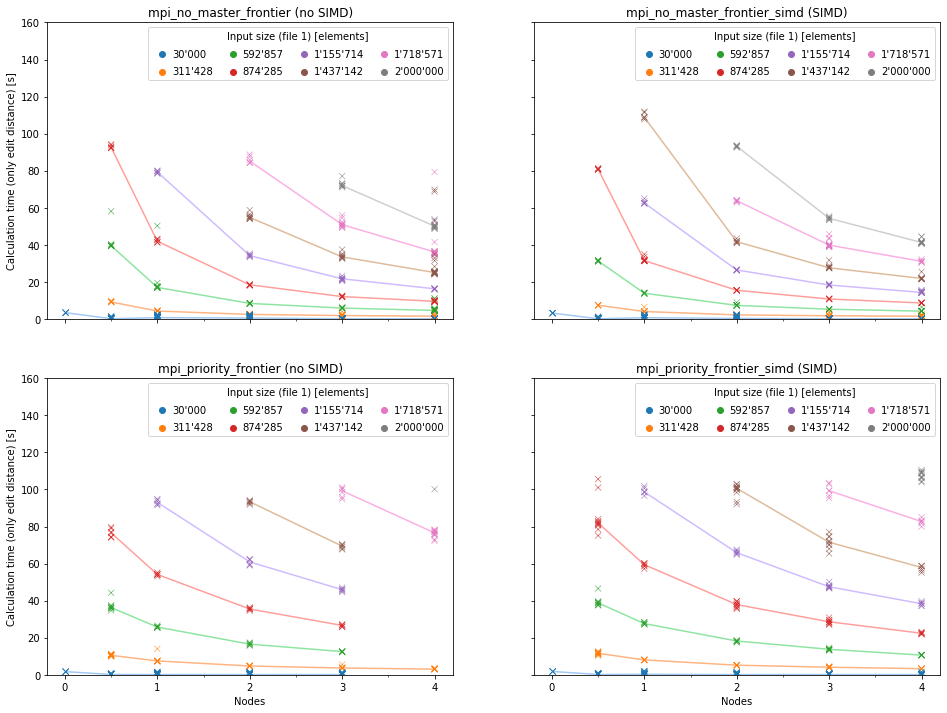

In [17]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(2, len(non_simd_diff_programs), figsize=(16, 12), sharex=True, sharey=True)
for group_i, (group, group_is_simd) in enumerate([(non_simd_diff_programs, False), (simd_diff_programs, True)]):
    for diff_program_i, diff_program in enumerate(group):
        temp = benchmark_results.copy()
        temp['seconds_until_len'] = temp['micros_until_len'] * 1e-6
        temp['mpi_nodes'] = temp['mpi_procs'] / 128
        temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == 'independent')]

        temp_2 = temp.groupby(['input_length_1', 'mpi_nodes'])['seconds_until_len'].median().unstack('input_length_1')

        this_ax = ax[diff_program_i][group_i]
        plot_scatter_with_lines(
            ax=this_ax,
            scatter_data=temp,
            line_data=temp_2,
            x_key='mpi_nodes',
            y_key='seconds_until_len',
            hue_key='input_length_1',
            sort_hue_keys=True,
            hue_to_label=format_input_size,
        )
        this_ax.set_xticks(np.arange(np.ceil(temp['mpi_nodes'].max()) + 1))
        this_ax.set_title(f'{diff_program} ({"SIMD" if group_is_simd else "no SIMD"})')
        this_ax.set_ylim(0, 160)

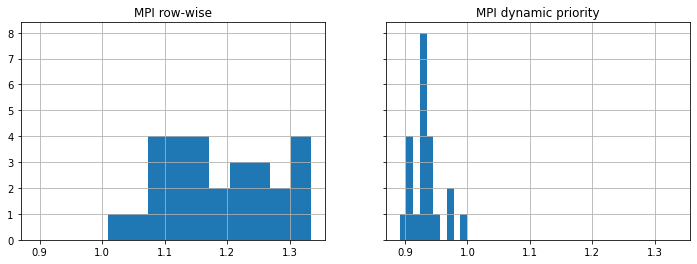

In [48]:
fig, ax = plt.subplots(1, len(non_simd_diff_programs), figsize=(12, 4), sharex=True, sharey=True)
for diff_program_i, (non_simd_diff_program, simd_diff_program) in enumerate(zip(non_simd_diff_programs, simd_diff_programs)):
    temp = benchmark_results.copy()
    temp = temp[(temp['diff_program'].isin([non_simd_diff_program, simd_diff_program])) & (temp['input_strategy'] == 'independent')]
    temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program'])['micros_until_len'].median().unstack('diff_program')
    temp = temp[(temp >= 1e6).all(axis=1)]
    temp = temp[non_simd_diff_program] / temp[simd_diff_program]
    temp = temp.reset_index(drop=True)

    this_ax = ax[diff_program_i]
    temp.hist(ax=this_ax, bins=10);
    this_ax.set_title(nice_name_map[simd_diff_program])

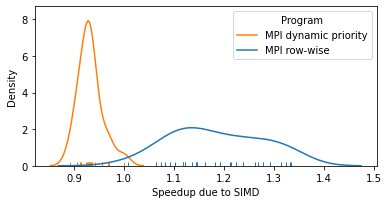

In [151]:
temp_2 = {}
for diff_program_i, (non_simd_diff_program, simd_diff_program) in enumerate(zip(non_simd_diff_programs, simd_diff_programs)):
    temp = benchmark_results.copy()
    temp = temp[(temp['diff_program'].isin([non_simd_diff_program, simd_diff_program])) & (temp['input_strategy'] == 'independent')]
    temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program'])['micros_until_len'].median().unstack('diff_program')
    temp = temp[(temp >= 1e6).all(axis=1)]
    temp = temp[non_simd_diff_program] / temp[simd_diff_program]
    temp_2[nice_name_map[simd_diff_program]] = temp
temp_2 = pd.DataFrame(temp_2)

g = sns.displot(temp_2, kind='kde', legend=False, rug=True, height=5.5/2, aspect=2);
g.ax.legend(sorted(temp_2.columns), title='Program'); # HACK make the legend text and colors match
g.ax.set_xlabel('Speedup due to SIMD')
sns.despine(top=False, right=False)

save_plot(g.fig, 'simd-comparison')